# Import

In [1]:
import tensorflow as tf
#import tensorflow.compat.v1 as tf
# tf.enable_eager_execution()
# tf.disable_v2_behavior()

import numpy as np
import pandas as pd
import os
import math


from scipy import stats #Analysis 
from scipy.stats import norm 

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [2]:
print(tf.__version__)

2.5.0


In [3]:
# # 한글 폰트가 깨지면 실행하세요! 
# # 한글 폰트가 따로 깔려있지 않은 컴퓨터에서는 해당 cell을 넘겨주세요!!! 
# import matplotlib.font_manager as fm
# fontlist = fm.findSystemFonts(fontpaths = None, fontext='ttf')
# # 아래 주석을 지워서 폰트 리스트를 확인하고 한글 폰트를 font_path에 추가합니다
# fontlist[:]

# from matplotlib import font_manager, rc
# #font_path = 'C:\\Users\\mtang\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare.ttf'
# font_path = 'C:\\WINDOWS\\Fonts\\NanumGothicLight.ttf'
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

# 1. Data Load  

In [4]:
# path = "./Dataset/"

# # original data : data 
# data =  pd.read_csv(path + "dementia_data.csv", parse_dates=['summary_date']) # 애초에 datatime 유형의 데이터를 읽어 올 때부터 형변환하기
# data


data =  pd.read_csv("../train.csv", parse_dates=['summary_date']) # 애초에 datatime 유형의 데이터를 읽어 올 때부터 형변환하기
data_label =  pd.read_csv("../train_label.csv")


In [5]:
# data + data_label 
# data['DIAG_NM'] = data_label

label_dict =  dict([(i,a) for i,a in zip(data_label['SAMPLE_EMAIL'], data_label['DIAG_NM'])])

# DIAG_NM
data['DIAG_NM'] = data['EMAIL'].map(label_dict)
data

,EMAIL,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_class_5min,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,...,sleep_temperature_deviation,sleep_temperature_trend_deviation,timezone,sleep_total,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8),DIAG_NM
0,nia+404@rowan.kr,2020-11-27,1.71875,730,2944,...,14346,0,417,0,...,-0.12,99.99,NaN,\r,2/1/1/1/1/1/2/2/1/1/1/1/1/1/2/2/2/3/2/2/2/2/2/...,0.9/0.9/1.4/1.9/1.1/0.9/0.9/1.1/1.3/1/0.9/1.1/...,0/73/73/73/72/71/70/71/71/71/70/70/73/72/74/74...,4/2/4/3/3/1/2/2/2/2/2/2/3/3/3/4/4/3/2/2/2/2/2/...,0/10/10/10/11/11/10/12/18/13/14/12/10/10/18/17...,CN
1,nia+404@rowan.kr,2020-11-28,1.40625,342,2449,...,6352,0,473,0,...,-0.32,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/2/2/...,1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,69/70/69/69/70/72/71/72/70/69/69/69/68/68/63/6...,2/4/2/2/2/2/3/1/2/2/4/4/2/2/2/2/2/2/2/2/2/2/4/...,23/23/26/24/18/13/15/14/17/20/24/30/23/25/22/1...,CN
2,nia+404@rowan.kr,2020-11-29,1.46875,401,2544,...,7297,0,586,0,...,0.07,99.99,NaN,\r,1/1/1/1/1/1/1/2/1/1/1/1/2/2/2/2/2/1/1/1/1/1/2/...,1.1/1.1/1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/74/73/73/74/74/74/71/71/70/70/69/70/68/66/69...,4/2/4/4/1/1/1/4/4/4/4/4/4/4/2/3/4/2/2/4/2/2/2/...,0/11/14/20/13/14/14/16/27/29/27/20/19/19/14/12...,CN
3,nia+404@rowan.kr,2020-11-30,0.34375,27,1850,...,491,0,176,0,...,-0.41,99.99,NaN,\r,2/1/2/2/1/2/1/1/2/1/1/1/1/1/2/1/1/1/1/1/2/2/2/...,0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/...,73/70/71/72/75/75/73/70/70/70/67/63/63/63/63/6...,4/4/4/4/3/3/3/2/4/4/4/2/2/2/2/2/2/2/2/4/2/2/2/...,24/28/19/17/12/10/17/20/23/23/25/31/26/25/34/3...,CN
4,nia+404@rowan.kr,2020-12-01,1.46875,333,2518,...,5861,0,646,0,...,-0.27,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/3/3/2/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/0/0/0/0/0/0/0/69/69/71/69/65/66/64/64/65/66/...,4/4/4/4/4/4/4/4/4/4/4/2/2/2/2/3/3/2/4/4/4/2/2/...,0/0/0/0/0/0/0/0/21/22/26/23/19/29/22/17/14/13/...,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,nia+206@rowan.kr,2020-12-22,1.34375,227,2316,...,3863,3,735,2,...,-0.16,99.99,NaN,\r,2/1/1/2/2/1/1/1/1/2/2/3/2/1/1/1/1/1/1/1/1/1/1/...,1.1/1.4/1.2/0.9/1.2/1.1/0.9/0.9/0.9/1/0.9/0.9/...,0/54/54/54/55/56/0/0/55/52/52/53/54/54/56/57/6...,4/4/4/2/2/2/2/4/2/2/2/1/1/1/1/4/2/2/3/3/3/3/3/...,0/35/39/28/26/41/0/0/52/31/27/30/21/22/27/40/3...,CN
9323,nia+206@rowan.kr,2020-12-24,1.34375,249,2351,...,4411,1,780,4,...,-0.09,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/2/3/2/2/2/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,68/66/67/67/68/69/69/70/71/71/71/69/72/70/70/7...,4/4/2/2/2/1/1/1/1/1/1/2/2/3/3/2/2/2/2/2/3/4/2/...,26/16/19/18/16/18/19/17/15/16/15/13/11/13/13/1...,CN
9324,nia+206@rowan.kr,2020-12-26,1.53125,570,2682,...,11057,1,518,1,...,0.41,99.99,NaN,\r,1/1/1/1/1/1/2/2/2/2/2/2/1/1/1/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/1.1/0.9/0.9/1.1/0.9/0.9/0.9/0....,0/0/65/65/66/67/69/72/73/72/73/74/73/74/75/75/...,4/4/2/2/2/2/2/2/2/2/2/2/4/4/4/4/2/3/3/3/2/2/4/...,0/0/13/12/12/13/12/12/12/16/13/12/13/17/13/18/...,CN
9325,nia+206@rowan.kr,2020-12-27,1.34375,295,2331,...,5135,4,578,0,...,0.27,99.99,NaN,\r,1/1/1/2/3/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.1/0.9/0.9/0.9/1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/...,0/0/0/64/64/64/64/65/65/66/66/66/66/68/68/68/6...,4/4/4/4/2/2/2/2/2/2/2/2/2/3/3/3/3/2/4/4/2/2/2/...,0/0/0/14/17/18/14/14/17/15/17/12/17/12/13/12/1...,CN


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9327 entries, 0 to 9326
Data columns (total 66 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   EMAIL                                     9327 non-null   object        
 1   summary_date                              9327 non-null   datetime64[ns]
 2   activity_average_met                      9327 non-null   float64       
 3   activity_cal_active                       9327 non-null   int64         
 4   activity_cal_total                        9327 non-null   int64         
 5   activity_class_5min                       9327 non-null   object        
 6   activity_daily_movement                   9327 non-null   int64         
 7   activity_high                             9327 non-null   int64         
 8   activity_inactive                         9327 non-null   int64         
 9   activity_inactivity_alerts    

# 3. Preprocessing 

**9,327 rows × 66 columns**

**9,327 rows × 51 columns**


**feature drop**
- timezone
- EMAIL
- sleep_temperature_trend_deviation, sleep_is_longest, sleep_total
    - 모든 값이 1, '\r', 99.99 이므로 제거 
- activity_class_5min, activity_met_1min
    - convert data
- sleep_hr_5min, sleep_hypnogram_5min, sleep_rmssd_5min
    - convert data


- CONVERT(activity_class_5min USING utf8)    
- CONVERT(activity_met_1min USING utf8)      
- CONVERT(sleep_hr_5min USING utf8)          
- CONVERT(sleep_hypnogram_5min USING utf8)  
- CONVERT(sleep_rmssd_5min USING utf8) 

**y variable**
- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)
    
So we may use 56 columns for training...

In [7]:
# column의 수가 많기 때문에 효율적으로 관리하기 위해서 
# column의 이름들을 묶어서 진행합시다
# drop_cols = ['timezone', 'EMAIL',
#              'activity_class_5min', 'activity_met_1min',
#              'sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min',
#              'sleep_is_longest', 'sleep_temperature_trend_deviation', 'sleep_total', 'sleep_temperature_deviation']
drop_cols = ['timezone',
             'activity_class_5min', 'activity_met_1min',
             'sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min',
             'sleep_is_longest', 'sleep_temperature_trend_deviation', 'sleep_total', 'sleep_temperature_deviation']

convert_cols = data.iloc[:, 60:65].columns

In [8]:
convert_cols

Index(['CONVERT(activity_class_5min USING utf8)',
       'CONVERT(activity_met_1min USING utf8)',
       'CONVERT(sleep_hr_5min USING utf8)',
       'CONVERT(sleep_hypnogram_5min USING utf8)',
       'CONVERT(sleep_rmssd_5min USING utf8)'],
      dtype='object')

In [9]:
# data -> processed_data 
# Drop Features 
processed_data = data.drop(drop_cols, axis=1).copy()
processed_data = processed_data.drop(convert_cols, axis=1).copy()
processed_data

,EMAIL,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,...,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,DIAG_NM
0,nia+404@rowan.kr,2020-11-27,1.71875,730,2944,14346,0,417,0,545,...,62,100,41,50,27,97,66,62,-0.12,CN
1,nia+404@rowan.kr,2020-11-28,1.40625,342,2449,6352,0,473,0,392,...,54,100,49,43,46,91,35,44,-0.32,CN
2,nia+404@rowan.kr,2020-11-29,1.46875,401,2544,7297,0,586,0,362,...,61,100,56,47,34,89,41,62,0.07,CN
3,nia+404@rowan.kr,2020-11-30,0.34375,27,1850,491,0,176,0,34,...,55,100,35,40,44,86,29,56,-0.41,CN
4,nia+404@rowan.kr,2020-12-01,1.46875,333,2518,5861,0,646,0,377,...,56,100,64,55,39,14,54,59,-0.27,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,nia+206@rowan.kr,2020-12-22,1.34375,227,2316,3863,3,735,2,155,...,76,100,53,46,74,97,84,82,-0.16,CN
9323,nia+206@rowan.kr,2020-12-24,1.34375,249,2351,4411,1,780,4,167,...,77,100,34,57,76,81,95,86,-0.09,CN
9324,nia+206@rowan.kr,2020-12-26,1.53125,570,2682,11057,1,518,1,332,...,65,100,1,56,69,86,89,64,0.41,CN
9325,nia+206@rowan.kr,2020-12-27,1.34375,295,2331,5135,4,578,0,173,...,81,100,9,59,86,89,98,97,0.27,CN


In [10]:
processed_data = processed_data.drop('summary_date', axis=1).copy()
processed_data

,EMAIL,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,...,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,DIAG_NM
0,nia+404@rowan.kr,1.71875,730,2944,14346,0,417,0,545,47,...,62,100,41,50,27,97,66,62,-0.12,CN
1,nia+404@rowan.kr,1.40625,342,2449,6352,0,473,0,392,8,...,54,100,49,43,46,91,35,44,-0.32,CN
2,nia+404@rowan.kr,1.46875,401,2544,7297,0,586,0,362,24,...,61,100,56,47,34,89,41,62,0.07,CN
3,nia+404@rowan.kr,0.34375,27,1850,491,0,176,0,34,1,...,55,100,35,40,44,86,29,56,-0.41,CN
4,nia+404@rowan.kr,1.46875,333,2518,5861,0,646,0,377,6,...,56,100,64,55,39,14,54,59,-0.27,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,nia+206@rowan.kr,1.34375,227,2316,3863,3,735,2,155,17,...,76,100,53,46,74,97,84,82,-0.16,CN
9323,nia+206@rowan.kr,1.34375,249,2351,4411,1,780,4,167,22,...,77,100,34,57,76,81,95,86,-0.09,CN
9324,nia+206@rowan.kr,1.53125,570,2682,11057,1,518,1,332,61,...,65,100,1,56,69,86,89,64,0.41,CN
9325,nia+206@rowan.kr,1.34375,295,2331,5135,4,578,0,173,30,...,81,100,9,59,86,89,98,97,0.27,CN


## 사람별 데이터를 모아볼 필요가 있을거 같다

In [11]:
group_pd  = processed_data.groupby(processed_data["EMAIL"])
group_pd = group_pd.mean()

In [12]:
group_pd

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_rmssd,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta
EMAIL,,,,,,,,,,,,,,,,,,,,,
nia+003@rowan.kr,1.263105,204.338710,2209.596774,3693.693548,0.806452,612.967742,0.822581,146.935484,18.596774,6.080645,...,27.790323,68.112903,74.500000,75.645161,57.870968,65.564516,78.532258,55.258065,70.016129,0.022097
nia+005@rowan.kr,1.364338,215.870588,1799.894118,4949.023529,0.094118,575.188235,0.611765,278.529412,14.235294,0.635294,...,50.470588,84.752941,87.870588,89.223529,84.000000,98.023529,84.094118,74.988235,82.035294,0.085882
nia+010@rowan.kr,1.390024,263.115385,2404.230769,3893.250000,0.557692,640.903846,0.365385,325.750000,7.865385,4.038462,...,33.884615,65.076923,97.692308,58.923077,63.769231,59.442308,79.019231,63.557692,56.096154,-0.045385
nia+013@rowan.kr,1.480175,498.376344,2581.860215,8869.139785,0.720430,469.967742,0.709677,316.483871,49.118280,5.053763,...,34.860215,74.935484,89.387097,97.784946,73.408602,88.526882,82.225806,39.279570,69.075269,-0.011828
nia+015@rowan.kr,1.385714,267.857143,2103.742857,5021.742857,2.057143,489.371429,0.285714,322.285714,28.600000,8.885714,...,72.771429,71.857143,86.600000,96.400000,66.800000,75.428571,74.885714,20.200000,75.628571,0.239714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nia+448@rowan.kr,1.361979,287.138889,2349.555556,5117.833333,2.027778,733.305556,0.472222,189.055556,28.055556,15.222222,...,19.250000,52.722222,94.138889,39.333333,44.111111,36.138889,82.361111,38.944444,48.888889,0.165278
nia+450@rowan.kr,1.570312,608.596154,2725.365385,11269.288462,10.115385,573.096154,0.230769,309.442308,62.576923,76.076923,...,30.750000,74.076923,78.730769,91.576923,73.673077,82.019231,77.942308,62.096154,67.923077,0.042308
nia+456@rowan.kr,1.559896,595.812500,2705.604167,11232.687500,6.270833,607.687500,0.541667,295.437500,65.083333,46.833333,...,34.625000,60.333333,88.562500,86.520833,57.062500,44.229167,84.625000,29.604167,52.458333,-0.106875


In [13]:
group_pd['DIAG_NM'] = group_pd.index.map(label_dict)

In [14]:
group_pd = group_pd.reset_index()

In [15]:
group_pd = group_pd.drop('EMAIL', axis = 1).copy()
group_pd

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,DIAG_NM
0,1.263105,204.338710,2209.596774,3693.693548,0.806452,612.967742,0.822581,146.935484,18.596774,6.080645,...,68.112903,74.500000,75.645161,57.870968,65.564516,78.532258,55.258065,70.016129,0.022097,MCI
1,1.364338,215.870588,1799.894118,4949.023529,0.094118,575.188235,0.611765,278.529412,14.235294,0.635294,...,84.752941,87.870588,89.223529,84.000000,98.023529,84.094118,74.988235,82.035294,0.085882,CN
2,1.390024,263.115385,2404.230769,3893.250000,0.557692,640.903846,0.365385,325.750000,7.865385,4.038462,...,65.076923,97.692308,58.923077,63.769231,59.442308,79.019231,63.557692,56.096154,-0.045385,MCI
3,1.480175,498.376344,2581.860215,8869.139785,0.720430,469.967742,0.709677,316.483871,49.118280,5.053763,...,74.935484,89.387097,97.784946,73.408602,88.526882,82.225806,39.279570,69.075269,-0.011828,MCI
4,1.385714,267.857143,2103.742857,5021.742857,2.057143,489.371429,0.285714,322.285714,28.600000,8.885714,...,71.857143,86.600000,96.400000,66.800000,75.428571,74.885714,20.200000,75.628571,0.239714,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,1.361979,287.138889,2349.555556,5117.833333,2.027778,733.305556,0.472222,189.055556,28.055556,15.222222,...,52.722222,94.138889,39.333333,44.111111,36.138889,82.361111,38.944444,48.888889,0.165278,MCI
144,1.570312,608.596154,2725.365385,11269.288462,10.115385,573.096154,0.230769,309.442308,62.576923,76.076923,...,74.076923,78.730769,91.576923,73.673077,82.019231,77.942308,62.096154,67.923077,0.042308,CN
145,1.559896,595.812500,2705.604167,11232.687500,6.270833,607.687500,0.541667,295.437500,65.083333,46.833333,...,60.333333,88.562500,86.520833,57.062500,44.229167,84.625000,29.604167,52.458333,-0.106875,CN
146,1.264844,212.125000,2221.250000,3606.875000,0.600000,497.325000,0.350000,215.075000,10.000000,4.425000,...,81.550000,92.575000,87.250000,73.225000,69.025000,75.825000,83.075000,85.100000,-0.004250,CN


# 4. Data Split 

모든 전처리와 y variable labeling이 완료되었다. train / valid / test data로 분할하고 용도에 맞게 model을 돌리도록 하자. 

In [16]:
group_pd.columns

Index(['activity_average_met', 'activity_cal_active', 'activity_cal_total',
       'activity_daily_movement', 'activity_high', 'activity_inactive',
       'activity_inactivity_alerts', 'activity_low', 'activity_medium',
       'activity_met_min_high', 'activity_met_min_inactive',
       'activity_met_min_low', 'activity_met_min_medium', 'activity_non_wear',
       'activity_rest', 'activity_score', 'activity_score_meet_daily_targets',
       'activity_score_move_every_hour', 'activity_score_recovery_time',
       'activity_score_stay_active', 'activity_score_training_frequency',
       'activity_score_training_volume', 'activity_steps', 'activity_total',
       'sleep_awake', 'sleep_breath_average', 'sleep_deep', 'sleep_duration',
       'sleep_efficiency', 'sleep_hr_average', 'sleep_hr_lowest',
       'sleep_light', 'sleep_midpoint_at_delta', 'sleep_midpoint_time',
       'sleep_onset_latency', 'sleep_period_id', 'sleep_rem', 'sleep_restless',
       'sleep_rmssd', 'sleep_score', 'sle

In [17]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV

# processed_data -> input_data 
input_data = group_pd.copy()

# y 변수와 X 변수 분할 관리 
input_data_y = input_data['DIAG_NM'].copy()
input_data_X = input_data.drop(['DIAG_NM'], axis=1)

In [18]:
# LabelEncoder
# y data를 LabelEncdoer로 한 번 더 labeling 합니다 -> 100만원, 10000만원... = 0, 1, ... 
# 추후에 DL에서 output을 맞춰주기 위함입니다, 최종 마지막에서 원래 label값(100만원, 1000만원...)으로 되돌립니다
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
input_data_y = le.fit_transform(list(input_data_y))
print("original gain_label \n", le.classes_)
print("gain_lable label \n", set(input_data_y))

original gain_label 
 ['CN' 'Dem' 'MCI']
gain_lable label 
 {0, 1, 2}


In [19]:
cn = 0 
dem = 0
mci = 0
for i in range(len(input_data_y)) :
    if input_data_y[i] == 0 : 
        cn += 1
    elif input_data_y[i] == 1 : 
        dem += 1
    elif input_data_y[i] == 2 : 
        mci += 1
print(cn , dem , mci)

97 10 41


# 5. Data Scaling 

scale data to get high accuracy
근데 과연 아래 알고리즘에도 영향이 있을까?

- RobustScaler  
- log transform

## Transform

In [20]:
input_data_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 48 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   activity_average_met               148 non-null    float64
 1   activity_cal_active                148 non-null    float64
 2   activity_cal_total                 148 non-null    float64
 3   activity_daily_movement            148 non-null    float64
 4   activity_high                      148 non-null    float64
 5   activity_inactive                  148 non-null    float64
 6   activity_inactivity_alerts         148 non-null    float64
 7   activity_low                       148 non-null    float64
 8   activity_medium                    148 non-null    float64
 9   activity_met_min_high              148 non-null    float64
 10  activity_met_min_inactive          148 non-null    float64
 11  activity_met_min_low               148 non-null    float64

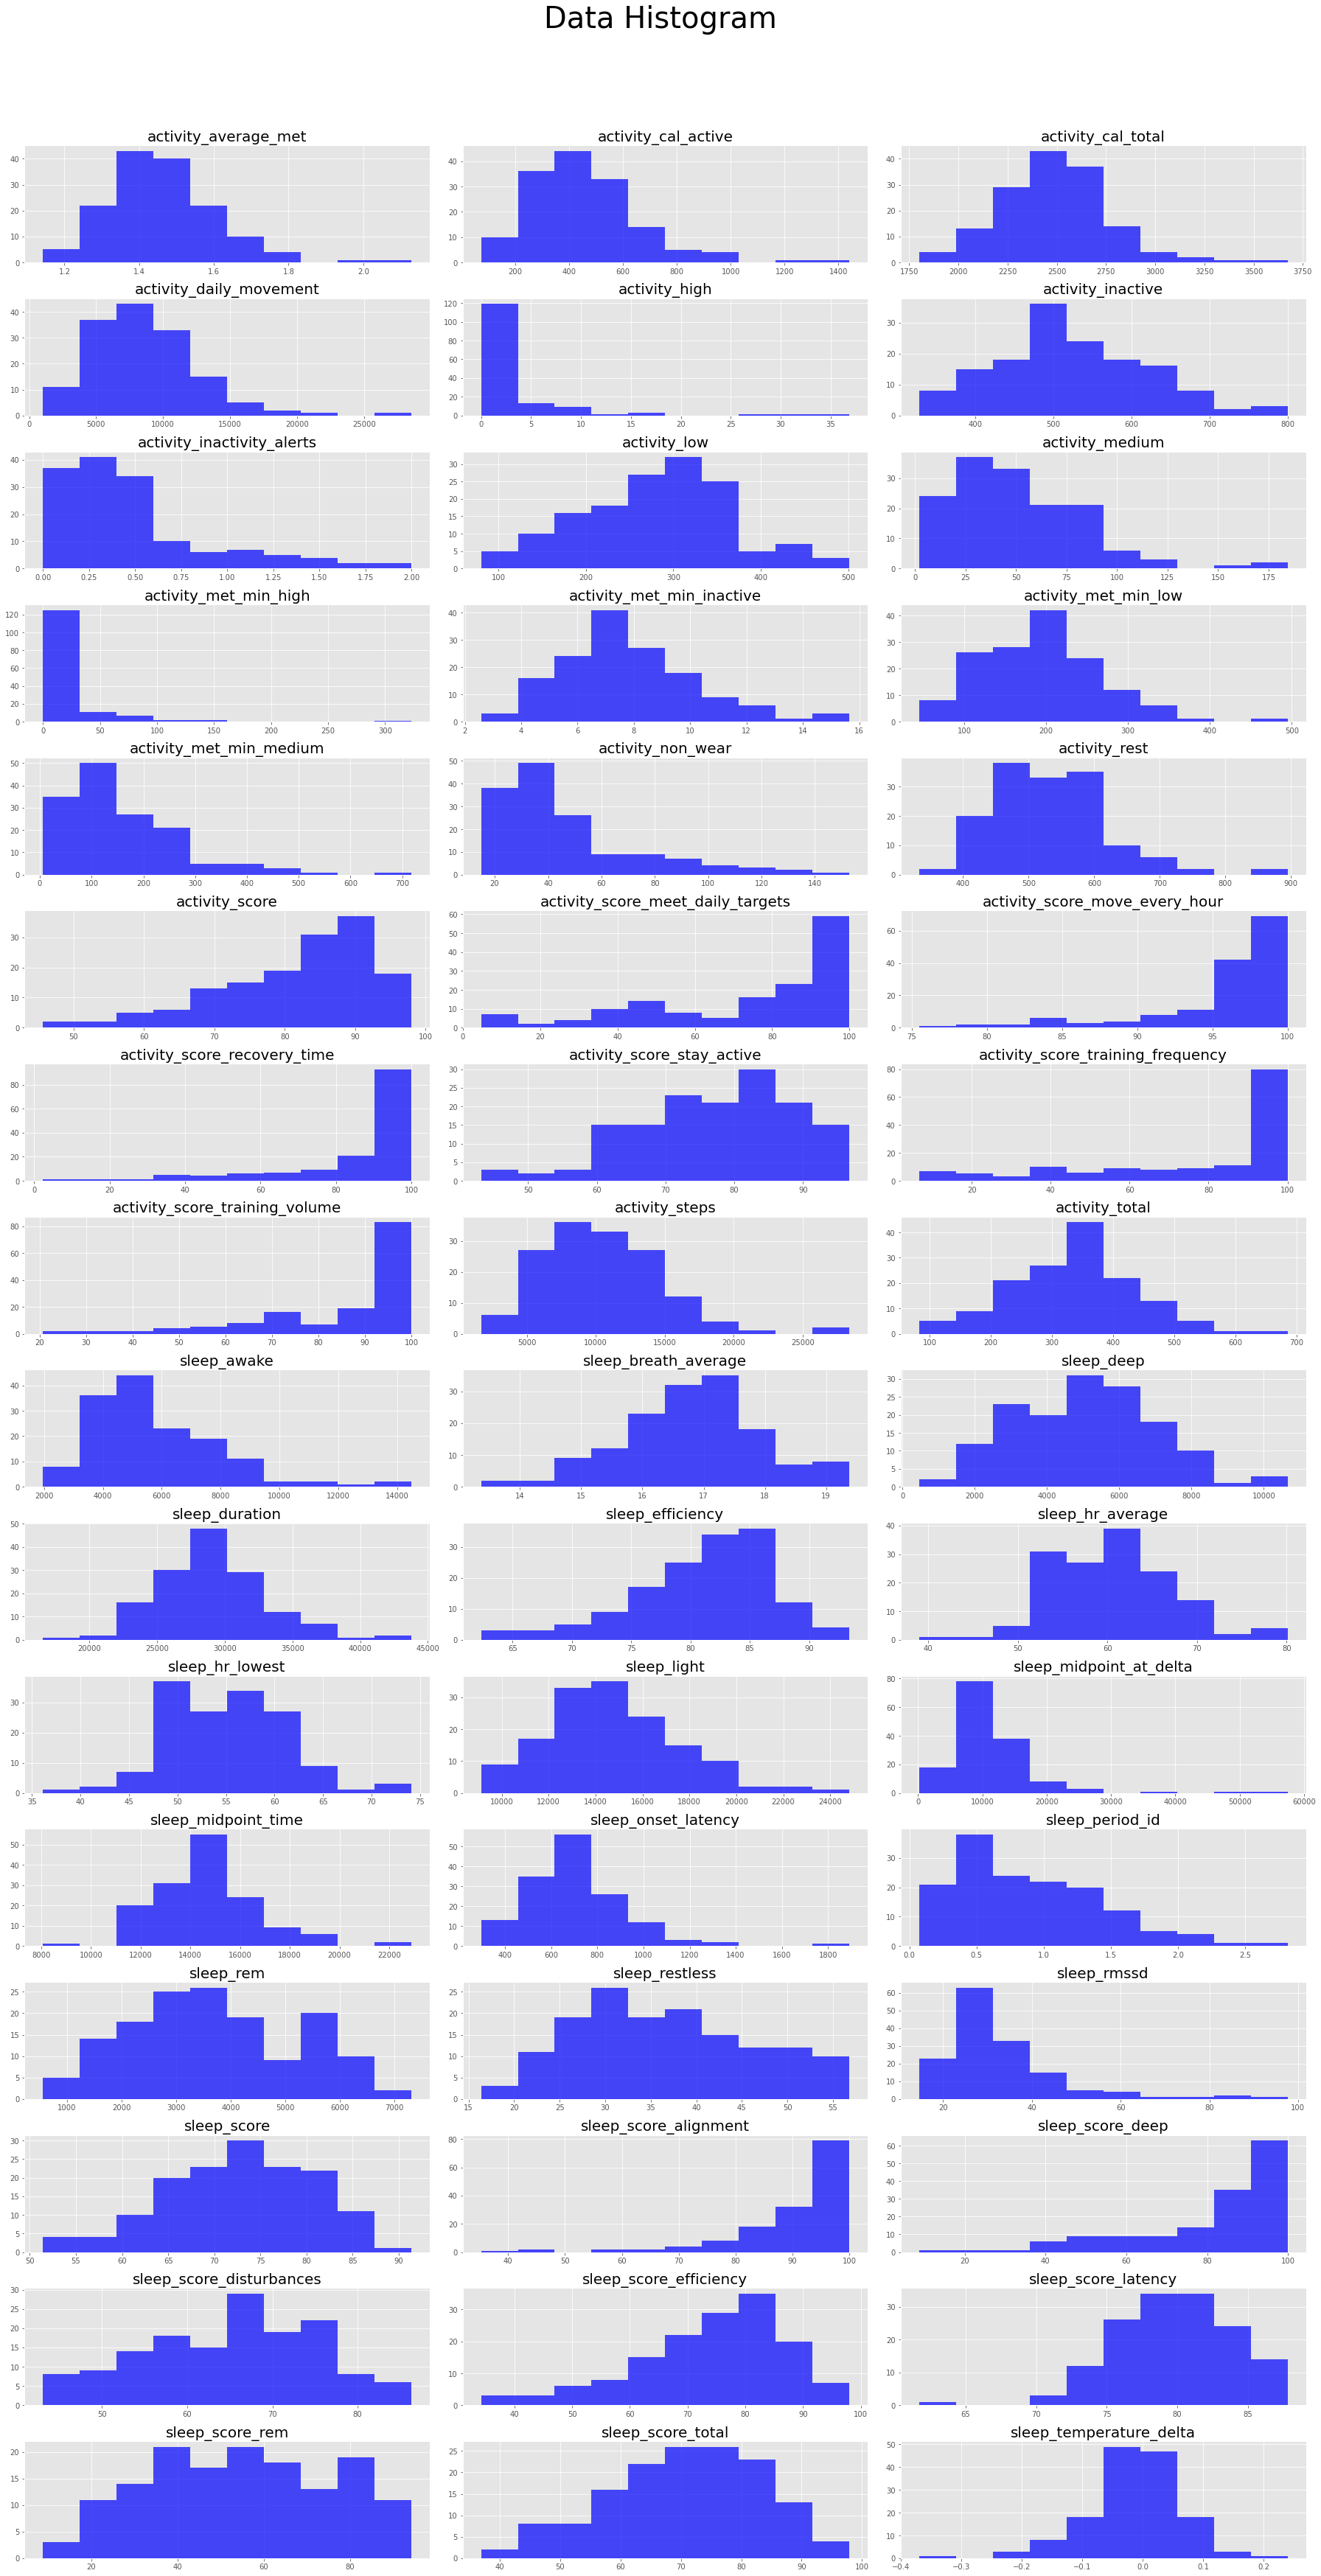

In [21]:
#data_activity = input_data_X.drop(['activity_met_1min', 'activity_class_5min'], axis=1)

plt.style.use("ggplot")

# 히스토그램을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(25,50))
plt.suptitle("Data Histogram", fontsize=40)

cols = input_data_X.columns
for i in range(len(cols)):
    plt.subplot(16,3,i+1)
    plt.title(cols[i], fontsize=20)
    if len(input_data_X[cols[i]].unique()) > 20:
        plt.hist(input_data_X[cols[i]], color='b', alpha=0.7)
    else:
        temp = input_data_X[cols[i]].value_counts()
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())
plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.show()

In [22]:
input_data_X['sleep_score_deep'] = np.power(input_data_X['sleep_score_deep']+1,2.5)
input_data_X['sleep_score_alignment'] = np.power(input_data_X['sleep_score_alignment']+1,2.5)
input_data_X['sleep_rmssd'] = np.log1p(input_data_X['sleep_rmssd'])
input_data_X['sleep_onset_latency'] = np.log1p(input_data_X['sleep_onset_latency'])

input_data_X['sleep_period_id'] = np.log1p(input_data_X['sleep_period_id'])
input_data_X['sleep_midpoint_at_delta'] = np.log1p(input_data_X['sleep_midpoint_at_delta'])

input_data_X['activity_score_training_volume'] = np.power(input_data_X['activity_score_training_volume']+1,2.5)
input_data_X['activity_score_training_frequency'] = np.power(input_data_X['activity_score_training_frequency']+1,2.5)
input_data_X['activity_score_recovery_time'] = np.power(input_data_X['activity_score_recovery_time']+1,2.5)
input_data_X['activity_score_move_every_hour'] = np.power(input_data_X['activity_score_move_every_hour']+1,2.5)
input_data_X['activity_score_meet_daily_targets'] = np.power(input_data_X['activity_score_meet_daily_targets']+1,2.5)

input_data_X['activity_score'] = np.exp(input_data_X['activity_score'])
input_data_X['activity_score_meet_daily_targets'] = np.power(input_data_X['activity_score_meet_daily_targets']+1,2.5)

input_data_X['activity_met_min_medium'] = np.log1p(input_data_X['activity_met_min_medium'])
input_data_X['activity_met_min_high'] = np.log1p(input_data_X['activity_met_min_high'])
input_data_X['activity_inactivity_alerts'] = np.log1p(input_data_X['activity_inactivity_alerts'])

input_data_X['activity_high'] = np.log1p(input_data_X['activity_high'])

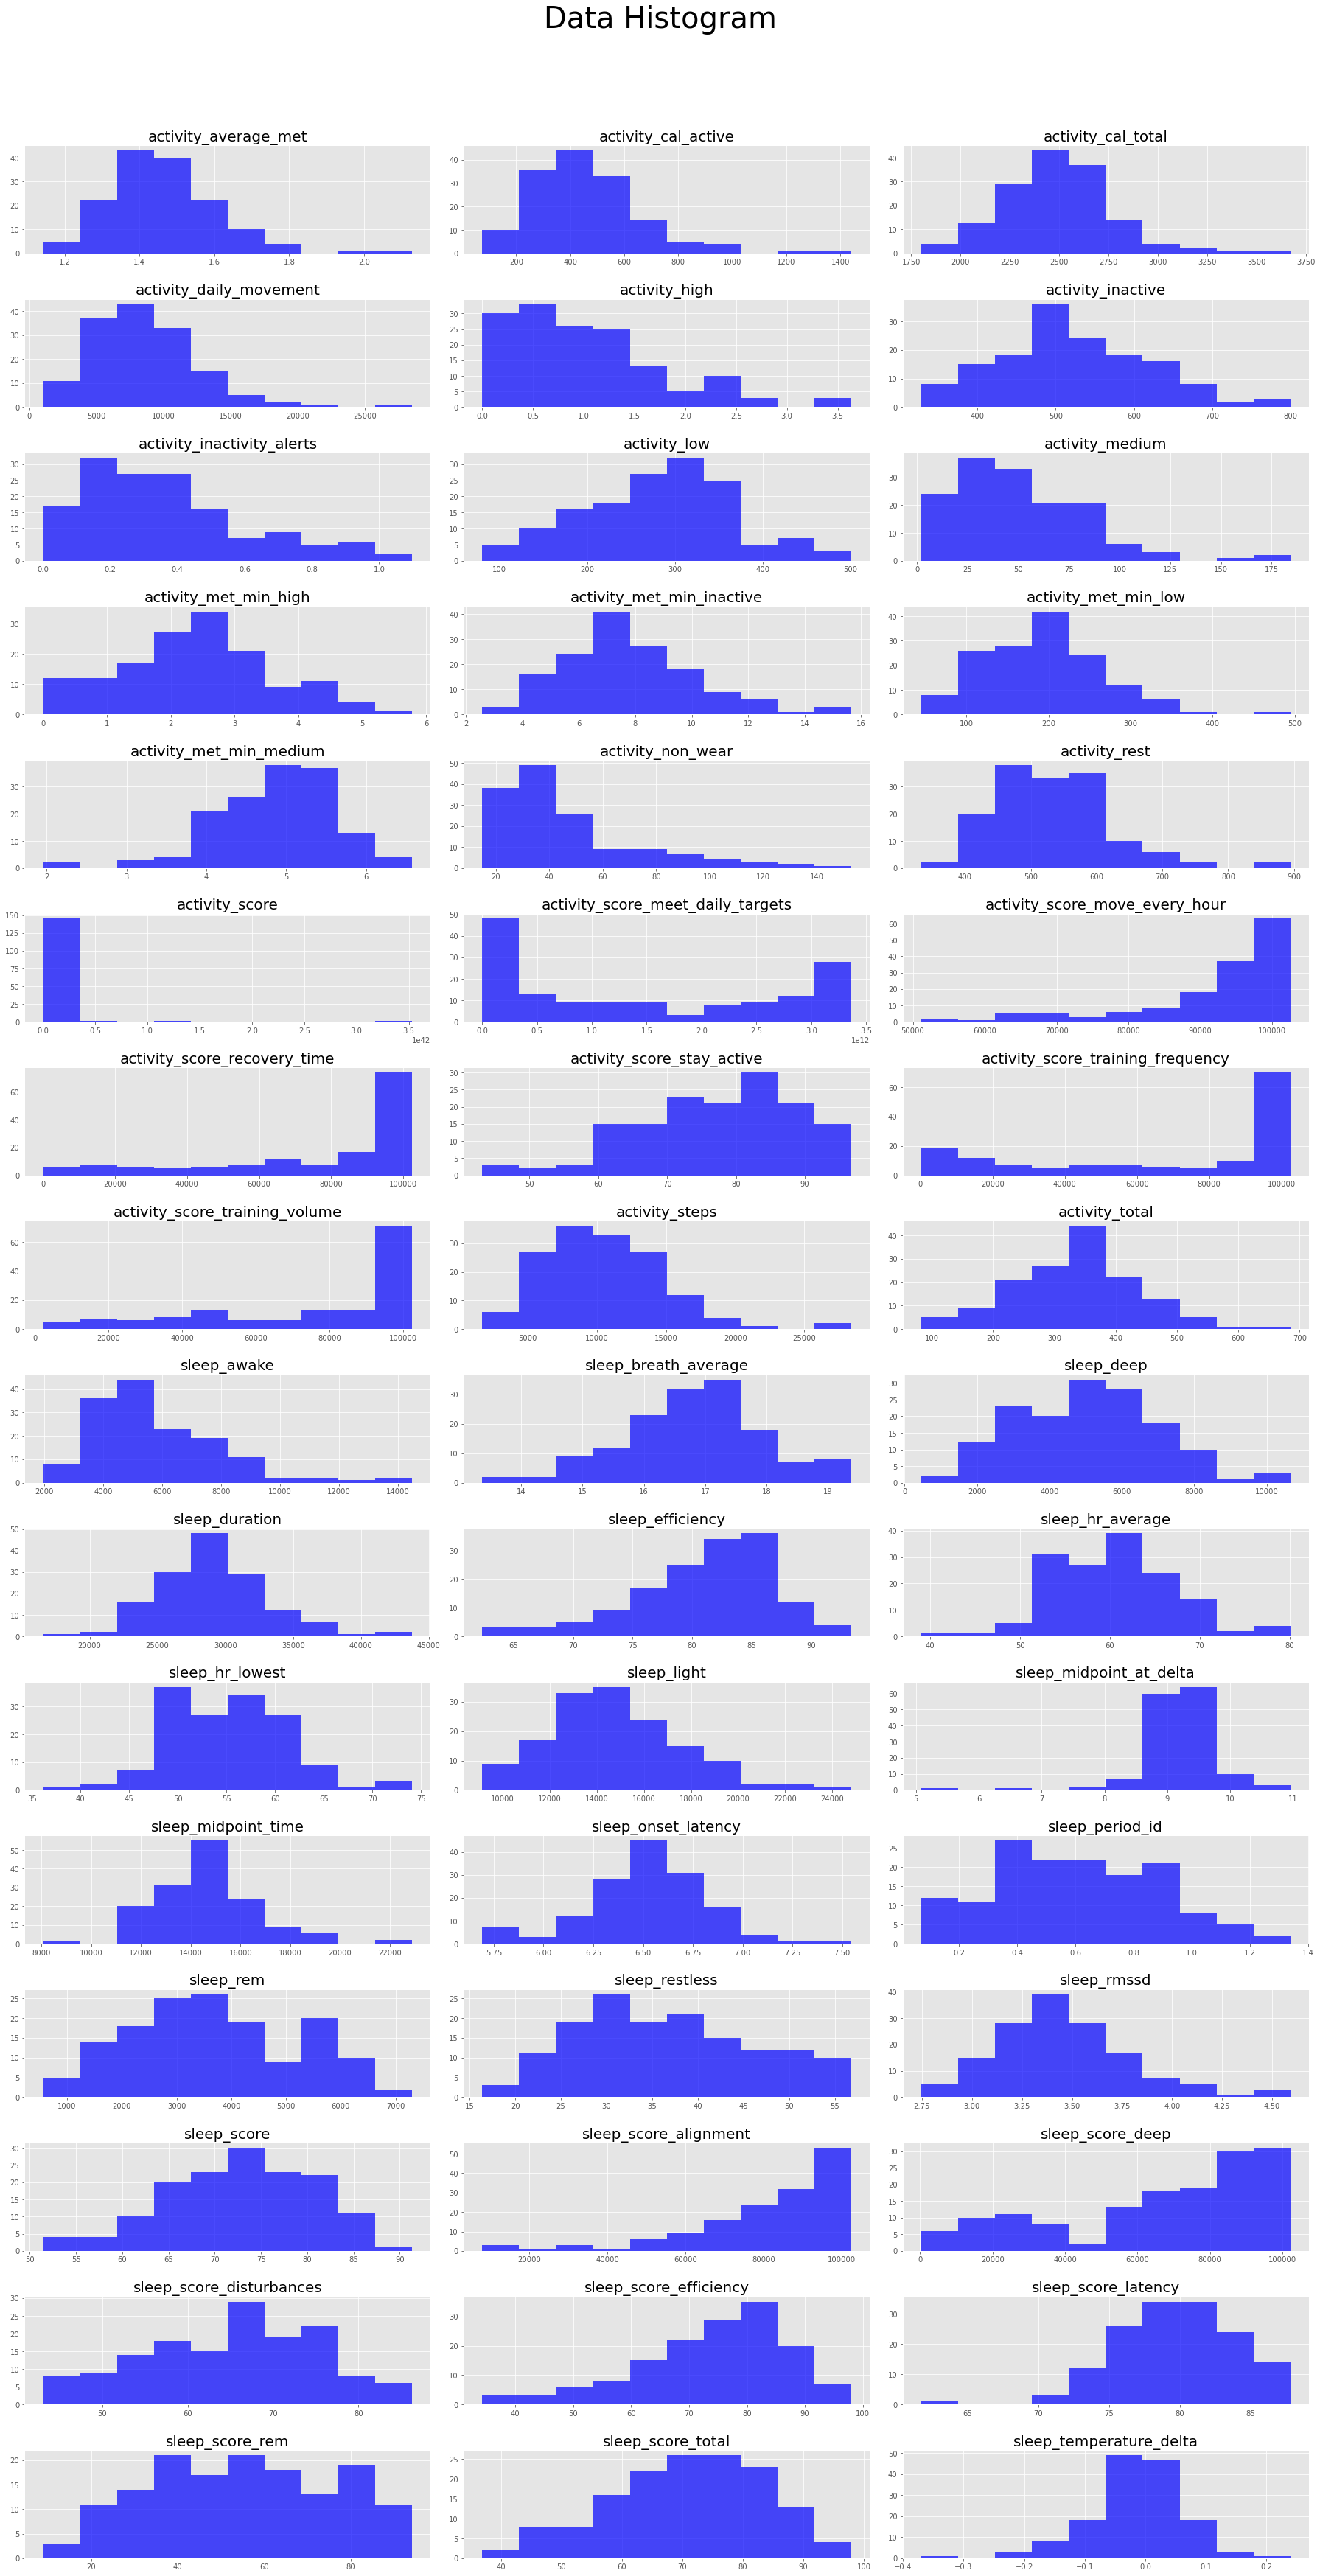

In [23]:
#data_activity = input_data_X.drop(['activity_met_1min', 'activity_class_5min'], axis=1)

plt.style.use("ggplot")

# 히스토그램을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(25,50))
plt.suptitle("Data Histogram", fontsize=40)

cols = input_data_X.columns
for i in range(len(cols)):
    plt.subplot(16,3,i+1)
    plt.title(cols[i], fontsize=20)
    if len(input_data_X[cols[i]].unique()) > 20:
        plt.hist(input_data_X[cols[i]], color='b', alpha=0.7)
    else:
        temp = input_data_X[cols[i]].value_counts()
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())
plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.show()

## RobustScaler

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

In [25]:
input_data_X

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_rmssd,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta
0,1.263105,204.338710,2209.596774,3693.693548,0.591364,612.967742,0.600253,146.935484,18.596774,1.957365,...,3.360039,68.112903,49529.891780,51429.447193,57.870968,65.564516,78.532258,55.258065,70.016129,0.022097
1,1.364338,215.870588,1799.894118,4949.023529,0.089948,575.188235,0.477330,278.529412,14.235294,0.491823,...,3.941011,84.752941,74455.217553,77321.368179,84.000000,98.023529,84.094118,74.988235,82.035294,0.085882
2,1.390024,263.115385,2404.230769,3893.250000,0.443205,640.903846,0.311436,325.750000,7.865385,1.617101,...,3.552046,65.076923,96762.762843,27796.189475,63.769231,59.442308,79.019231,63.557692,56.096154,-0.045385
3,1.480175,498.376344,2581.860215,8869.139785,0.542574,469.967742,0.536305,316.483871,49.118280,1.800680,...,3.579628,74.935484,77672.286997,96989.991116,73.408602,88.526882,82.225806,39.279570,69.075269,-0.011828
4,1.385714,267.857143,2103.742857,5021.742857,1.117481,489.371429,0.251314,322.285714,28.600000,2.291091,...,4.300972,71.857143,71822.458231,93626.198951,66.800000,75.428571,74.885714,20.200000,75.628571,0.239714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,1.361979,287.138889,2349.555556,5117.833333,1.107829,733.305556,0.386773,189.055556,28.055556,2.786382,...,3.008155,52.722222,88286.680421,10331.426467,44.111111,36.138889,82.361111,38.944444,48.888889,0.165278
144,1.570312,608.596154,2725.365385,11269.288462,2.408330,573.096154,0.207639,309.442308,62.576923,4.344804,...,3.457893,74.076923,56762.940514,82462.568104,73.673077,82.019231,77.942308,62.096154,67.923077,0.042308
145,1.559896,595.812500,2705.604167,11232.687500,1.983871,607.687500,0.432864,295.437500,65.083333,3.867723,...,3.573048,60.333333,75912.888959,71660.298092,57.062500,44.229167,84.625000,29.604167,52.458333,-0.106875
146,1.264844,212.125000,2221.250000,3606.875000,0.470004,497.325000,0.300105,215.075000,10.000000,1.691018,...,3.332205,81.550000,84703.155459,73162.204858,73.225000,69.025000,75.825000,83.075000,85.100000,-0.004250


In [26]:
Rscaler = RobustScaler()
result = Rscaler.fit_transform(input_data_X)
pd.options.display.float_format = '{:.3f}'.format
input_data_X_scaled = pd.DataFrame(result, columns=input_data_X.columns)

In [27]:
input_data_X_scaled

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_rmssd,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta
0,-1.057,-0.926,-0.875,-0.856,-0.311,0.871,1.009,-1.214,-0.619,-0.255,...,-0.204,-0.449,-1.655,-0.592,-0.490,-0.649,-0.243,0.008,-0.083,0.368
1,-0.474,-0.880,-2.157,-0.612,-0.856,0.547,0.575,-0.084,-0.723,-1.244,...,1.440,1.021,-0.575,0.072,1.134,1.372,0.753,0.558,0.619,1.174
2,-0.326,-0.691,-0.266,-0.817,-0.472,1.111,-0.011,0.322,-0.875,-0.484,...,0.340,-0.717,0.391,-1.199,-0.123,-1.030,-0.156,0.239,-0.896,-0.485
3,0.193,0.247,0.290,0.151,-0.364,-0.354,0.783,0.242,0.108,-0.360,...,0.418,0.154,-0.436,0.576,0.476,0.781,0.419,-0.437,-0.138,-0.061
4,-0.351,-0.672,-1.206,-0.598,0.261,-0.188,-0.224,0.292,-0.381,-0.029,...,2.459,-0.118,-0.689,0.490,0.065,-0.035,-0.896,-0.969,0.244,3.117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,-0.488,-0.596,-0.437,-0.579,0.250,1.902,0.255,-0.852,-0.394,0.305,...,-1.200,-1.808,0.024,-1.647,-1.346,-2.481,0.443,-0.447,-1.317,2.177
144,0.711,0.687,0.739,0.618,1.663,0.530,-0.378,0.182,0.429,1.357,...,0.073,0.078,-1.342,0.204,0.492,0.376,-0.348,0.198,-0.206,0.623
145,0.651,0.636,0.677,0.611,1.202,0.826,0.418,0.061,0.488,1.035,...,0.399,-1.136,-0.512,-0.073,-0.540,-1.978,0.848,-0.707,-1.109,-1.262
146,-1.047,-0.895,-0.838,-0.873,-0.443,-0.120,-0.051,-0.629,-0.824,-0.434,...,-0.283,0.738,-0.131,-0.035,0.465,-0.433,-0.728,0.783,0.798,0.035


<AxesSubplot:>

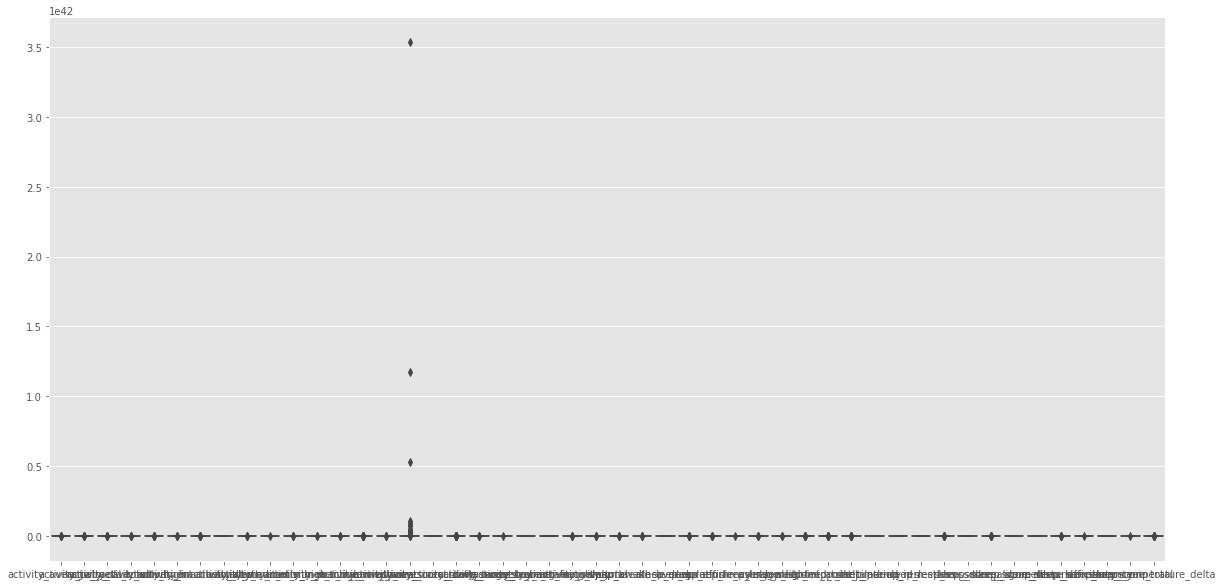

In [28]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=input_data_X)

<AxesSubplot:>

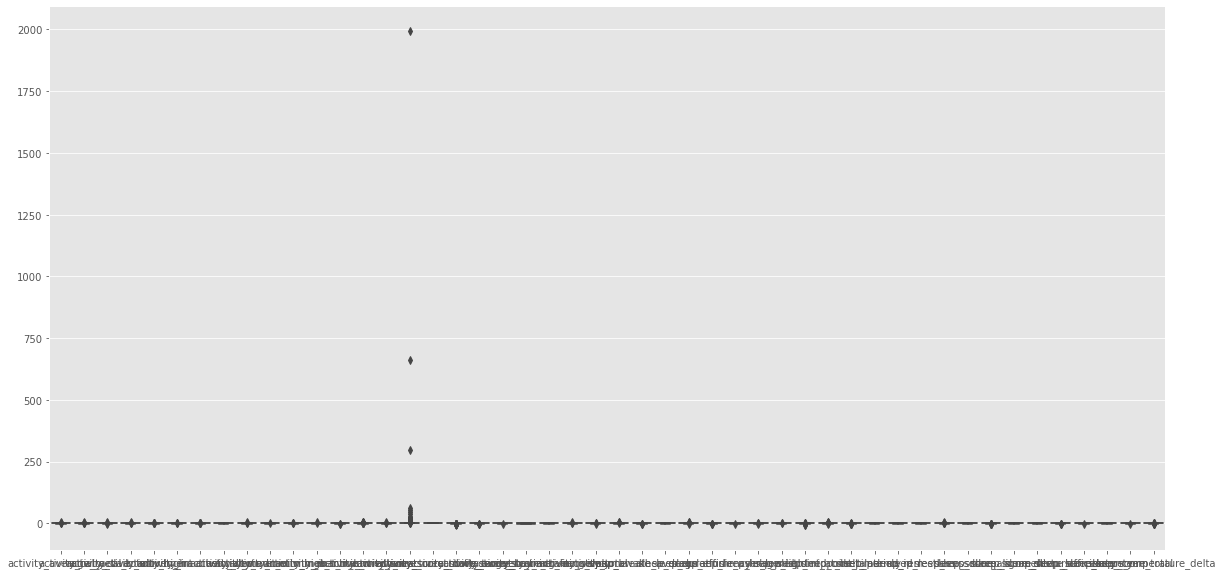

In [29]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=input_data_X_scaled)

In [30]:
input_data_X_scaled.describe()

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_rmssd,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta
count,148.000,148.000,148.000,148.000,148.000,148.000,148.000,148.000,148.000,148.000,...,148.000,148.000,148.000,148.000,148.000,148.000,148.000,148.000,148.000,148.000
mean,0.089,0.093,0.029,0.113,0.156,0.111,0.190,-0.061,0.158,0.037,...,0.084,-0.047,-0.267,-0.203,-0.046,-0.124,-0.024,0.004,-0.022,-0.051
std,0.815,0.841,0.876,0.796,0.839,0.829,0.871,0.729,0.780,0.796,...,0.928,0.694,0.855,0.730,0.624,0.802,0.737,0.593,0.741,1.017
min,-1.750,-1.447,-2.157,-1.374,-0.953,-1.569,-1.111,-1.787,-1.013,-1.575,...,-1.941,-1.923,-3.458,-1.904,-1.411,-2.600,-3.254,-1.287,-2.017,-4.588
25%,-0.443,-0.499,-0.508,-0.465,-0.457,-0.415,-0.458,-0.598,-0.410,-0.439,...,-0.504,-0.514,-0.630,-0.599,-0.549,-0.551,-0.500,-0.449,-0.481,-0.488
50%,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000
75%,0.557,0.501,0.492,0.535,0.543,0.585,0.542,0.402,0.590,0.561,...,0.496,0.486,0.370,0.401,0.451,0.449,0.500,0.551,0.519,0.512
max,3.925,4.005,3.699,3.979,2.995,2.471,2.769,1.829,3.329,2.326,...,3.280,1.605,0.640,0.710,1.278,1.372,1.416,1.095,1.546,3.117


In [31]:
# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X_scaled, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

# 6. Modeling - ML

- Linear model
    - Logistic Linear Regression 
- Tree model 
    - RandomForest 
- Gradient Boosting model 
    - XGB
    - LGBM
    - CatBoost 

In [32]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from lightgbm import plot_importance 
from xgboost import XGBClassifier
from xgboost import plot_importance
#from keras.callbacks import EarlyStopping, ModelCheckpoint
# Learning task parameters
# multi:softmax : softmax를 이용한 다중 클래스 분류 
# multi:softptob : softmax를 이용한 다중 클래스에 대한 예상 확률 반환 
# mlogloss : multiclass logloss 

model_rf = RandomForestClassifier()

model_xgb = XGBClassifier(
    eval_metric='mlogloss', use_label_encoder=False )
model_lgbm = LGBMClassifier()

In [33]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X_scaled.iloc[train_index], input_data_X_scaled.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_rf.fit(x_train, y_train)
    pred = model_rf.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.4583,  학습 데이터 크기 : 94,  검증 데이터 크기 : 24
#1 검증 세트 인덱스 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 26]

#2 교차 검증 정확도 : 0.5833,  학습 데이터 크기 : 94,  검증 데이터 크기 : 24
#2 검증 세트 인덱스 : [13 24 25 27 28 29 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]

#3 교차 검증 정확도 : 0.4583,  학습 데이터 크기 : 94,  검증 데이터 크기 : 24
#3 검증 세트 인덱스 : [30 32 50 51 52 53 54 56 57 58 59 60 61 62 63 64 66 67 68 69 70 73 74 76]

#4 교차 검증 정확도 : 0.4348,  학습 데이터 크기 : 95,  검증 데이터 크기 : 23
#4 검증 세트 인덱스 : [55 65 72 75 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 94 96 99]

#5 교차 검증 정확도 : 0.5217,  학습 데이터 크기 : 95,  검증 데이터 크기 : 23
#5 검증 세트 인덱스 : [ 71  93  95  97  98 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117]

## 평균 검증 정확도: 0.49128000000000005


In [34]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X_scaled.iloc[train_index], input_data_X_scaled.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_xgb.fit(x_train, y_train)
    pred = model_xgb.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.3333,  학습 데이터 크기 : 94,  검증 데이터 크기 : 24
#1 검증 세트 인덱스 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 26]

#2 교차 검증 정확도 : 0.4583,  학습 데이터 크기 : 94,  검증 데이터 크기 : 24
#2 검증 세트 인덱스 : [13 24 25 27 28 29 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]

#3 교차 검증 정확도 : 0.4167,  학습 데이터 크기 : 94,  검증 데이터 크기 : 24
#3 검증 세트 인덱스 : [30 32 50 51 52 53 54 56 57 58 59 60 61 62 63 64 66 67 68 69 70 73 74 76]

#4 교차 검증 정확도 : 0.3478,  학습 데이터 크기 : 95,  검증 데이터 크기 : 23
#4 검증 세트 인덱스 : [55 65 72 75 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 94 96 99]

#5 교차 검증 정확도 : 0.5217,  학습 데이터 크기 : 95,  검증 데이터 크기 : 23
#5 검증 세트 인덱스 : [ 71  93  95  97  98 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117]

## 평균 검증 정확도: 0.41556


In [35]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X_scaled.iloc[train_index], input_data_X_scaled.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_lgbm.fit(x_train, y_train)
    pred = model_lgbm.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.3333,  학습 데이터 크기 : 94,  검증 데이터 크기 : 24
#1 검증 세트 인덱스 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 26]

#2 교차 검증 정확도 : 0.5,  학습 데이터 크기 : 94,  검증 데이터 크기 : 24
#2 검증 세트 인덱스 : [13 24 25 27 28 29 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]

#3 교차 검증 정확도 : 0.5833,  학습 데이터 크기 : 94,  검증 데이터 크기 : 24
#3 검증 세트 인덱스 : [30 32 50 51 52 53 54 56 57 58 59 60 61 62 63 64 66 67 68 69 70 73 74 76]

#4 교차 검증 정확도 : 0.3913,  학습 데이터 크기 : 95,  검증 데이터 크기 : 23
#4 검증 세트 인덱스 : [55 65 72 75 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 94 96 99]

#5 교차 검증 정확도 : 0.5652,  학습 데이터 크기 : 95,  검증 데이터 크기 : 23
#5 검증 세트 인덱스 : [ 71  93  95  97  98 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117]

## 평균 검증 정확도: 0.47462


In [36]:
pred_rf = model_rf.predict(test_X)

pred_xgb_prob = model_xgb.predict_proba(test_X)
pred_xgb = np.argmax(pred_xgb_prob, axis=1)

pred_lgbm_prob = model_lgbm.predict_proba(test_X)
pred_lgbm = np.argmax(pred_lgbm_prob, axis=1)

## KNN

전처리 및 정규화를 추가 할수록 좋아질 가능성 높음

In [37]:
from sklearn.neighbors import KNeighborsClassifier

#Setup arrays to store training and test accuracies
neighbors = np.arange(1,13)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(tr_val_X, tr_val_y)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(tr_val_X, tr_val_y)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(test_X, test_y) 

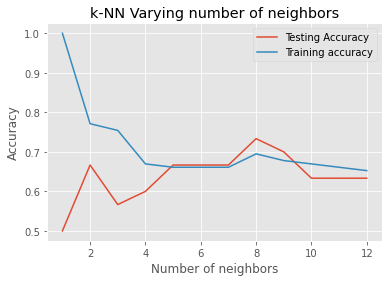

In [38]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [39]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(tr_val_X, tr_val_y)

KNeighborsClassifier(n_neighbors=8)

In [40]:
knn.score(test_X, test_y)

0.7333333333333333

In [41]:
pred_knn = knn.predict(test_X)
print(classification_report(test_y, pred_knn))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        20
           1       0.00      0.00      0.00         2
           2       1.00      0.25      0.40         8

    accuracy                           0.73        30
   macro avg       0.57      0.42      0.41        30
weighted avg       0.74      0.73      0.66        30



C:\Users\drago\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\drago\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\drago\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## deep learning process

In [42]:
import numpy as np
##import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pprint import pprint

from tensorflow.keras.layers import Dense, LSTM, Embedding, Activation, SimpleRNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from sklearn.metrics import accuracy_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


%matplotlib inline
print(tf.__version__)

2.5.0


In [43]:
data_rnn = data.iloc[:, 60:]

In [44]:
data_rnn.iloc[:,-1]

0       CN
1       CN
2       CN
3       CN
4       CN
        ..
9322    CN
9323    CN
9324    CN
9325    CN
9326    CN
Name: DIAG_NM, Length: 9327, dtype: object

In [45]:
data_rnn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9327 entries, 0 to 9326
Data columns (total 6 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   CONVERT(activity_class_5min USING utf8)   9327 non-null   object
 1   CONVERT(activity_met_1min USING utf8)     9327 non-null   object
 2   CONVERT(sleep_hr_5min USING utf8)         9327 non-null   object
 3   CONVERT(sleep_hypnogram_5min USING utf8)  9327 non-null   object
 4   CONVERT(sleep_rmssd_5min USING utf8)      9327 non-null   object
 5   DIAG_NM                                   9327 non-null   object
dtypes: object(6)
memory usage: 437.3+ KB


In [46]:
signal_df = data_rnn#['CONVERT(activity_class_5min USING utf8)']
#signal_df = pd.DataFrame(signal_df)

In [47]:
signal_list = list(data_rnn['CONVERT(activity_class_5min USING utf8)'].str.split('/'))
signal_df1 = pd.DataFrame(signal_list)
signal_df1 = signal_df1.drop(288, axis=1).astype('float').copy()
signal_df1

,0,1,2,3,4,5,6,7,8,9,...,278,279,280,281,282,283,284,285,286,287
0,2.000,1.000,1.000,1.000,1.000,1.000,2.000,2.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
1,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
2,1.000,1.000,1.000,1.000,1.000,1.000,1.000,2.000,1.000,1.000,...,1.000,2.000,2.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
3,2.000,1.000,2.000,2.000,1.000,2.000,1.000,1.000,2.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
4,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,2.000,2.000,2.000,2.000,1.000,1.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,2.000,1.000,1.000,2.000,2.000,1.000,1.000,1.000,1.000,2.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
9323,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,2.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
9324,1.000,1.000,1.000,1.000,1.000,1.000,2.000,2.000,2.000,2.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
9325,1.000,1.000,1.000,2.000,3.000,2.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


<AxesSubplot:>

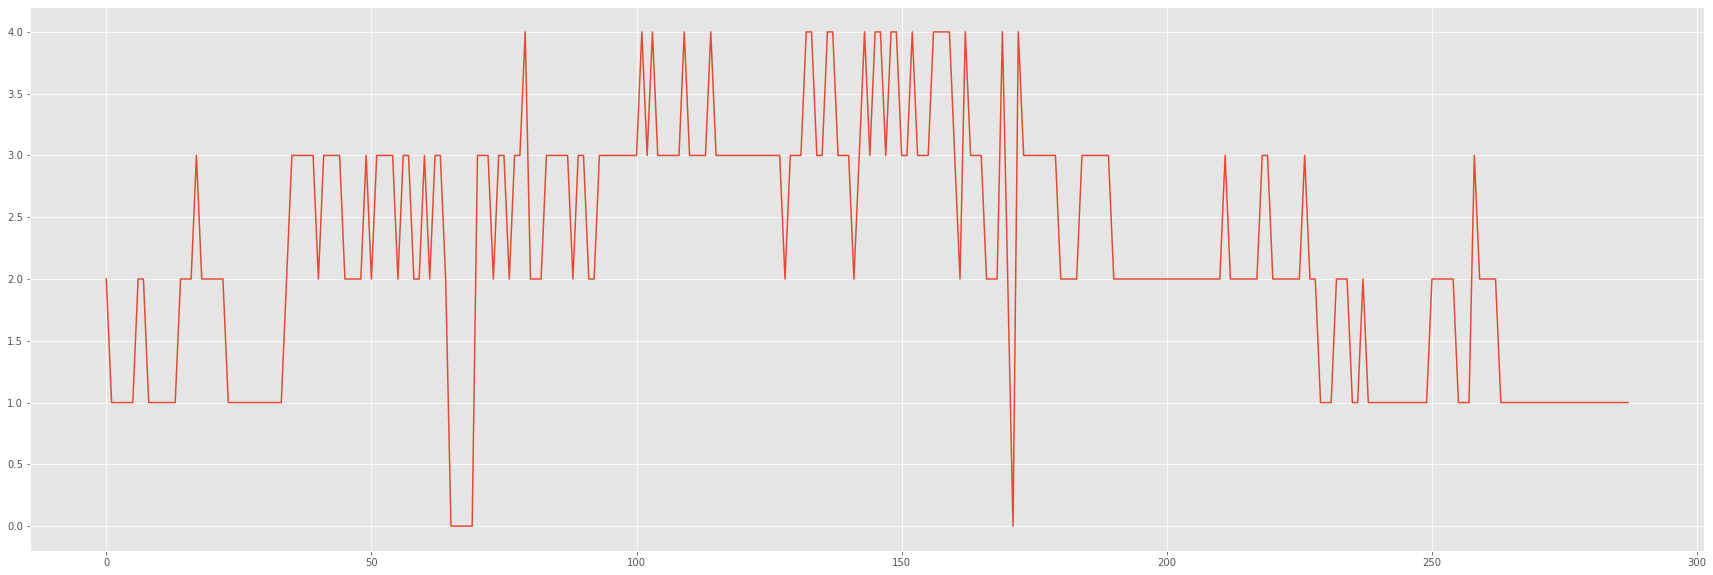

In [48]:
plt.figure(figsize=(30, 10))
signal_df1.iloc[0].plot()

In [49]:
signal_df1.iloc[0]

0     2.000
1     1.000
2     1.000
3     1.000
4     1.000
       ... 
283   1.000
284   1.000
285   1.000
286   1.000
287   1.000
Name: 0, Length: 288, dtype: float64

In [50]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
signal_df["target"] = le.fit_transform(list(data_rnn["DIAG_NM"]))
print("original gain_label \n", le.classes_)
print("gain_lable label \n", set(input_data_y))

original gain_label 
 ['CN' 'Dem' 'MCI']
gain_lable label 
 {0, 1, 2}


In [51]:
signal_df

,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8),DIAG_NM,target
0,2/1/1/1/1/1/2/2/1/1/1/1/1/1/2/2/2/3/2/2/2/2/2/...,0.9/0.9/1.4/1.9/1.1/0.9/0.9/1.1/1.3/1/0.9/1.1/...,0/73/73/73/72/71/70/71/71/71/70/70/73/72/74/74...,4/2/4/3/3/1/2/2/2/2/2/2/3/3/3/4/4/3/2/2/2/2/2/...,0/10/10/10/11/11/10/12/18/13/14/12/10/10/18/17...,CN,0
1,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/2/2/...,1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,69/70/69/69/70/72/71/72/70/69/69/69/68/68/63/6...,2/4/2/2/2/2/3/1/2/2/4/4/2/2/2/2/2/2/2/2/2/2/4/...,23/23/26/24/18/13/15/14/17/20/24/30/23/25/22/1...,CN,0
2,1/1/1/1/1/1/1/2/1/1/1/1/2/2/2/2/2/1/1/1/1/1/2/...,1.1/1.1/1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/74/73/73/74/74/74/71/71/70/70/69/70/68/66/69...,4/2/4/4/1/1/1/4/4/4/4/4/4/4/2/3/4/2/2/4/2/2/2/...,0/11/14/20/13/14/14/16/27/29/27/20/19/19/14/12...,CN,0
3,2/1/2/2/1/2/1/1/2/1/1/1/1/1/2/1/1/1/1/1/2/2/2/...,0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/...,73/70/71/72/75/75/73/70/70/70/67/63/63/63/63/6...,4/4/4/4/3/3/3/2/4/4/4/2/2/2/2/2/2/2/2/4/2/2/2/...,24/28/19/17/12/10/17/20/23/23/25/31/26/25/34/3...,CN,0
4,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/3/3/2/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/0/0/0/0/0/0/0/69/69/71/69/65/66/64/64/65/66/...,4/4/4/4/4/4/4/4/4/4/4/2/2/2/2/3/3/2/4/4/4/2/2/...,0/0/0/0/0/0/0/0/21/22/26/23/19/29/22/17/14/13/...,CN,0
...,...,...,...,...,...,...,...
9322,2/1/1/2/2/1/1/1/1/2/2/3/2/1/1/1/1/1/1/1/1/1/1/...,1.1/1.4/1.2/0.9/1.2/1.1/0.9/0.9/0.9/1/0.9/0.9/...,0/54/54/54/55/56/0/0/55/52/52/53/54/54/56/57/6...,4/4/4/2/2/2/2/4/2/2/2/1/1/1/1/4/2/2/3/3/3/3/3/...,0/35/39/28/26/41/0/0/52/31/27/30/21/22/27/40/3...,CN,0
9323,1/1/1/1/1/1/1/1/1/1/2/3/2/2/2/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,68/66/67/67/68/69/69/70/71/71/71/69/72/70/70/7...,4/4/2/2/2/1/1/1/1/1/1/2/2/3/3/2/2/2/2/2/3/4/2/...,26/16/19/18/16/18/19/17/15/16/15/13/11/13/13/1...,CN,0
9324,1/1/1/1/1/1/2/2/2/2/2/2/1/1/1/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/1.1/0.9/0.9/1.1/0.9/0.9/0.9/0....,0/0/65/65/66/67/69/72/73/72/73/74/73/74/75/75/...,4/4/2/2/2/2/2/2/2/2/2/2/4/4/4/4/2/3/3/3/2/2/4/...,0/0/13/12/12/13/12/12/12/16/13/12/13/17/13/18/...,CN,0
9325,1/1/1/2/3/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.1/0.9/0.9/0.9/1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/...,0/0/0/64/64/64/64/65/65/66/66/66/66/68/68/68/6...,4/4/4/4/2/2/2/2/2/2/2/2/2/3/3/3/3/2/4/4/2/2/2/...,0/0/0/14/17/18/14/14/17/15/17/12/17/12/13/12/1...,CN,0


In [52]:
signal_df[:2]

,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8),DIAG_NM,target
0,2/1/1/1/1/1/2/2/1/1/1/1/1/1/2/2/2/3/2/2/2/2/2/...,0.9/0.9/1.4/1.9/1.1/0.9/0.9/1.1/1.3/1/0.9/1.1/...,0/73/73/73/72/71/70/71/71/71/70/70/73/72/74/74...,4/2/4/3/3/1/2/2/2/2/2/2/3/3/3/4/4/3/2/2/2/2/2/...,0/10/10/10/11/11/10/12/18/13/14/12/10/10/18/17...,CN,0
1,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/2/2/...,1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,69/70/69/69/70/72/71/72/70/69/69/69/68/68/63/6...,2/4/2/2/2/2/3/1/2/2/4/4/2/2/2/2/2/2/2/2/2/2/4/...,23/23/26/24/18/13/15/14/17/20/24/30/23/25/22/1...,CN,0


#### data split for rnn model

In [53]:
rnn_y = signal_df['target'].copy()
rnn_X = signal_df.drop(['target'], axis=1)

In [54]:
tr_rnn_X, te_rnn_X, tr_rnn_y, te_rnn_y = train_test_split(
    rnn_X, 
    rnn_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = rnn_y # Classification 중요 option
)

In [55]:
tr_rnn_X = tr_rnn_X.iloc[: , 0:5]
te_rnn_X = te_rnn_X.iloc[: , 0:5]

In [56]:
tr_rnn_X['CONVERT(activity_class_5min USING utf8)'] = tr_rnn_X['CONVERT(activity_class_5min USING utf8)'].str.replace("/","")
tr_rnn_X['CONVERT(activity_met_1min USING utf8)'] = tr_rnn_X['CONVERT(activity_met_1min USING utf8)'].str.replace("/","")
tr_rnn_X['CONVERT(sleep_hypnogram_5min USING utf8)'] = tr_rnn_X['CONVERT(sleep_hypnogram_5min USING utf8)'].str.replace("/","")
tr_rnn_X['CONVERT(sleep_rmssd_5min USING utf8)'] = tr_rnn_X['CONVERT(sleep_rmssd_5min USING utf8)'].str.replace("/","")
tr_rnn_X['CONVERT(sleep_hr_5min USING utf8)'] = tr_rnn_X['CONVERT(sleep_hr_5min USING utf8)'].str.replace("/","")

te_rnn_X['CONVERT(sleep_hr_5min USING utf8)'] = te_rnn_X['CONVERT(sleep_hr_5min USING utf8)'].str.replace("/","")
te_rnn_X['CONVERT(activity_class_5min USING utf8)'] = te_rnn_X['CONVERT(activity_class_5min USING utf8)'].str.replace("/","")
te_rnn_X['CONVERT(activity_met_1min USING utf8)'] = te_rnn_X['CONVERT(activity_met_1min USING utf8)'].str.replace("/","")
te_rnn_X['CONVERT(sleep_hypnogram_5min USING utf8)'] = te_rnn_X['CONVERT(sleep_hypnogram_5min USING utf8)'].str.replace("/","")
te_rnn_X['CONVERT(sleep_rmssd_5min USING utf8)'] = te_rnn_X['CONVERT(sleep_rmssd_5min USING utf8)'].str.replace("/","")

In [57]:
tr_rnn_X['CONVERT(activity_class_5min USING utf8)']

1153    2222111111121111111111111111122223333444222353...
8833    1111111111111111111111111111111111111111244444...
1276    1111121111111111111122233322223333332322223444...
2752    1111111112122222221222222220000000000000000000...
3589    1111111111111121111111112111111111113333323332...
                              ...                        
1902    1111111111112223211111122211111221111111333333...
8926    2122222112121111111121111111112122233334322322...
5326    1111111122222333432222222111222222222222232222...
6797    1111111111111211111111111232222222222222223233...
7670    1111132121111111222332222122122222211111123322...
Name: CONVERT(activity_class_5min USING utf8), Length: 7461, dtype: object

In [58]:
tr_rnn_X2= tr_rnn_X.to_numpy()

In [59]:
num_set = ['<pad>'] + sorted(list(set(''.join(tr_rnn_X2[1]))))
idx2num = {idx : char for idx, char in enumerate(num_set)}
num2idx = {char : idx for idx, char in enumerate(num_set)}

print(num_set)
print(idx2num)
print(num2idx)

['<pad>', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
{0: '<pad>', 1: '.', 2: '0', 3: '1', 4: '2', 5: '3', 6: '4', 7: '5', 8: '6', 9: '7', 10: '8', 11: '9'}
{'<pad>': 0, '.': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11}


In [60]:
x_data = list(map(lambda tr_rnn_X : [num2idx.get(char) for char in tr_rnn_X], tr_rnn_X))
x_data_len = list(map(lambda tr_rnn_X : len(tr_rnn_X), x_data))
x_test = list(map(lambda te_rnn_X : [num2idx.get(char) for char in te_rnn_X1], te_rnn_X1))

NameError: name 'te_rnn_X1' is not defined

In [ ]:
x_data

In [ ]:
x_data = pad_sequences(sequences = x_data, maxlen = 350,
                       padding = 'post', truncating = 'post')
x_test = pad_sequences(sequences = x_test, maxlen = 350,
                       padding = 'post', truncating = 'post')

In [ ]:
print(x_data)

In [ ]:
x_data[1]

In [ ]:
tr_rnn_y=tr_rnn_y.reset_index()
tr_rnn_y = tr_rnn_y["target"]
tr_rnn_y.values.tolist()
tr_rnn_y = np.array(tr_rnn_y)
tr_rnn_y = tr_rnn_y.astype("int32")

te_rnn_y=te_rnn_y.reset_index()
te_rnn_y = te_rnn_y["target"]
te_rnn_y.values.tolist()
te_rnn_y = np.array(te_rnn_y)
te_rnn_y = te_rnn_y.astype("int32")

In [ ]:
print(tr_rnn_y.shape)
print(x_data.shape)

In [ ]:
# num_classes = 3
# hidden_dims = [20, 20]
# max_sequence = 288

# input_dim = len(num2idx)
# output_dim = len(num2idx)
# one_hot = np.eye(len(num2idx))

def lstm():
    model = Sequential()
    model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim,
                               input_length=max_sequence,
                               embeddings_initializer=keras.initializers.Constant(one_hot)))
    model.add(LSTM(50, input_shape = (1,1), return_sequences =True ,activation='relu'))
    model.add(LSTM(50))
    model.add(Dense(3))
    model.add(Activation('softmax'))

    adam = optimizers.Adam(lr = 0.01)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    model.summary()
    
    return model

# model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim,
#                            input_length=max_sequence,
#                            embeddings_initializer=keras.initializers.Constant(one_hot)))
#model.add(layers.SimpleRNN(units=hidden_dims[0], return_sequences=True))
#model.add(layers.TimeDistributed(layers.Dropout(rate = .2)))
#model.add(layers.SimpleRNN(units=hidden_dims[1]))
#model.add(layers.Dropout(rate = .2))
#model.add(layers.Dense(units=num_classes))

In [ ]:
# def loss_fn(model, x, y):
#     return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(
#         y_true=y, y_pred=model(x), from_logits=True))
# lr = .01
# epochs = 20
# batch_size = 2
# opt = tf.keras.optimizers.Adam(learning_rate = lr)

In [ ]:
# tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, tr_rnn_y))
# tr_dataset = tr_dataset.shuffle(buffer_size = 4)
# tr_dataset = tr_dataset.batch(batch_size = batch_size)

# print(tr_dataset)

In [ ]:
model = KerasClassifier(build_fn = lstm, epochs = 10, batch_size = 64, verbose = 1)
model.fit(x_data , tr_rnn_y)
pred_train = model.predict(x_data)
pred_val = model.predict(x_test)
print("train set의 accuracy : {}, validation set의 예측결과 : {}" .format(accuracy_score(tr_rnn_y, pred_train), accuracy_score(te_rnn_y, pred_val)))

pred_test = model.predict(x_test)
print("최종 평가(test set): {}".format(accuracy_score(te_rnn_y, pred_test)))

## new

In [ ]:
max_sequence = 576
X = pad_sequences(x_data, maxlen=max_sequence, padding='post', truncating='post')
train_ds = tf.data.Dataset.from_tensor_slices((X, tr_rnn_y)).shuffle(buffer_size=4).batch(batch_size=2)
print(train_ds)

In [ ]:
# te_rnn_y=te_rnn_y.reset_index()
# te_rnn_y = te_rnn_y["target"]
# te_rnn_y.values.tolist()
# te_rnn_y = np.array(te_rnn_y)
# te_rnn_y = te_rnn_y.astype("int32")
te_rnn_y 

In [ ]:
len(X)

In [ ]:
input_dim = len(num2idx)
output_dim = len(num2idx)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model = Sequential([
    Embedding(input_dim=input_dim, output_dim=output_dim,
              mask_zero=True, input_length=max_sequence,
              trainable=False, embeddings_initializer=tf.keras.initializers.random_normal()),
    SimpleRNN(units=10),
    Dense(3)
])

model.summary()

In [ ]:
def loss_fn(model, X, y):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true=y, 
                                                                          y_pred=model(X), 
                                                                          from_logits=True))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [ ]:
tr_loss_hist = []

for e in range(30):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb in train_ds:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x_mb, y_mb)
            
        grads = tape.gradient(tr_loss, sources=model.variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
    
    if (e + 1) % 5 == 0:
        print('epoch: {:3}, tr_loss: {:3f}'.format(e + 1, avg_tr_loss))

In [ ]:
# creating loss function
def loss_fn(model, x, y, training):
    return tf.losses.softmax_cross_entropy(labels=y, logits=model(x, training))
# creating and optimizer
lr = .01
epochs = 30
batch_size = 2
opt = tf.optimizers.Adam(learning_rate= lr)
# generating data pipline
tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, tr_rnn_y))
tr_dataset = tr_dataset.shuffle(buffer_size=4)
tr_dataset = tr_dataset.batch(batch_size=batch_size)
print(tr_dataset)
# training
tr_loss_hist = []
for epoch in range(epochs):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb in tr_dataset:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x=x_mb, y=y_mb, training=True)
        grads = tape.gradient(target=tr_loss, sources=model.variables)
        opt.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    else:
        avg_tr_loss /= tr_step
        tr_loss_hist.append(avg_tr_loss)
    
    if (epoch + 1) % 5 == 0:
        print('epoch : {:3}, tr_loss : {:.3f}'.format(epoch + 1, avg_tr_loss))

In [ ]:
yhat = model.predict(x_data)
yhat = np.argmax(yhat, axis=-1)
print('accuracy : {:2%}'.format(np.mean(yhat == y_data)))
accuracy : 100.000000%
plt.plot(tr_loss_hist)

In [ ]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

### RNN

### resnet

### Lstm

# 7. Evaluation

- precision(정밀도) : True -> True 
- Recall(재현율) : True인 것을 맞춘 비율 
- F1 score : precision 과 recall의 조화평균

In [ ]:
def show_pred(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    
    df_result = pd.DataFrame(list(zip(true_y, pred)), columns=['true_y', 'prediction'])
    return df_result
    
def show_prediction_error(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    error = pred - true_y
    plt.hist(error, bins=25)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    
def feature_importance(model_xgb) : 
    %matplotlib inline
    plt.rcParams['axes.unicode_minus'] = False
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = fm.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

    fig, ax = plt.subplots(figsize=(10,12))
    plot_importance(model_xgb, ax=ax)
    
def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

In [ ]:
print(classification_report(test_y, pred_rf))

In [ ]:
print(classification_report(test_y, pred_xgb))

In [ ]:
print(classification_report(test_y, pred_lgbm))